

>  **Import Libraries**


In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json
import re
import matplotlib.pyplot as plt


**Load Data**

In [23]:
# Load data
data_path = "/content/Sarcasm_Headlines_Dataset.json"
data = [json.loads(line) for line in open(data_path, 'r')]
df = pd.DataFrame(data)

# Clean data
texts = df['headline']
labels = df['is_sarcastic']

# Tokenize and pad sequences
max_words = 5000  # Vocabulary size
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Get word index for embedding matrix
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


PreprocessData

In [24]:
# Drop irrelevant column
df = df.drop(columns=['article_link'])

print(df.head())
# Extract cleaned headlines and labels
texts = df['headline']
labels = df['is_sarcastic']

# Function to clean text
def clean_text(text):
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean the text data
texts_cleaned = texts.apply(clean_text)

# Tokenization and padding
max_words = 5000  # Maximum vocabulary size
max_len = 50      # Maximum sequence length

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_cleaned)
sequences = tokenizer.texts_to_sequences(texts_cleaned)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Verify the shapes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


                                            headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0
Training data shape: (21367, 50)
Test data shape: (5342, 50)


Loading Pretrained GLove Embeddings

In [27]:
# Load pre-trained embeddings
embedding_dim = 300  # Dimension of GloVe vectors
embedding_file = '/content/glove.6B.300d.txt'

# Create embedding matrix
embedding_index = {}
with open(embedding_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector


Build a BiLSTM Model

In [28]:
# Build model
def build_bi_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_len,
                        weights=[embedding_matrix],
                        trainable=True,
                        name='Embedding'))
    model.add(Bidirectional(LSTM(64, return_sequences=True, name='BiLSTM_1')))
    model.add(Bidirectional(LSTM(32, name='BiLSTM_2')))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', name='Dense_1'))
    model.add(Dense(1, activation='sigmoid', name='Output'))

    return model

# Compile the model
model = build_bi_lstm()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (21367, 50)
y_train shape: (21367,)


In [30]:
X_train = np.array(X_train)
y_train = np.array(y_train)


Train Model

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=10,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8796 - loss: 0.2930 - val_accuracy: 0.8428 - val_loss: 0.3759
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9167 - loss: 0.2149 - val_accuracy: 0.8432 - val_loss: 0.4054
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9424 - loss: 0.1532 - val_accuracy: 0.8264 - val_loss: 0.5266
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9573 - loss: 0.1181 - val_accuracy: 0.8187 - val_loss: 0.6658


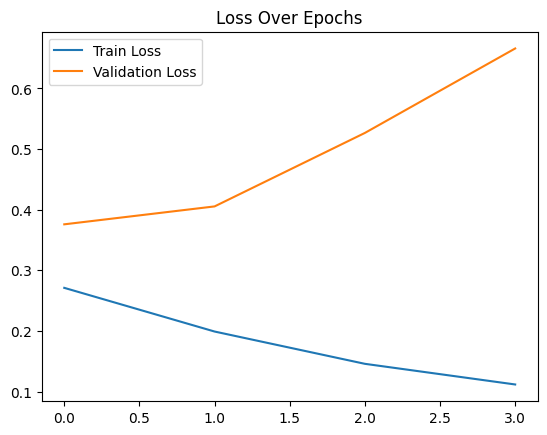

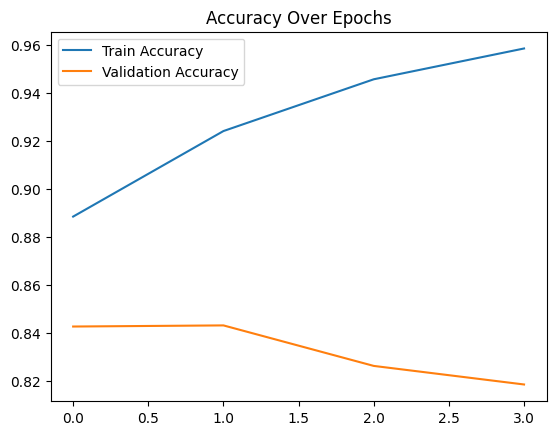

In [33]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()


Testing the model

In [34]:
# Example headlines
new_headlines = [
    "I'm so thrilled about getting no sleep tonight!",
    "Breaking news: A man wins $1 million lottery."
]

# Preprocess new headlines
new_sequences = tokenizer.texts_to_sequences(new_headlines)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_len, padding='post')

# Predict sarcasm
predictions = model.predict(new_padded_sequences)

# Display results
for i, headline in enumerate(new_headlines):
    print(f"Headline: {headline}")
    print(f"Sarcastic: {'Yes' if predictions[i] > 0.5 else 'No'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Headline: I'm so thrilled about getting no sleep tonight!
Sarcastic: No
Headline: Breaking news: A man wins $1 million lottery.
Sarcastic: Yes


In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00


In [ ]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

# Define a hypermodel class for BiLSTM
class BiLSTMSarcasmHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            weights=[embedding_matrix],
                            trainable=hp.Boolean('trainable_embedding', default=False),
                            name='Embedding'))
        model.add(Bidirectional(LSTM(
            units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
            return_sequences=True,
            name='BiLSTM_1')))
        model.add(Bidirectional(LSTM(
            units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16),
            name='BiLSTM_2')))
        model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu', name='Dense_1'))
        model.add(Dense(1, activation='sigmoid', name='Output'))

        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model


In [ ]:
from keras_tuner.tuners import RandomSearch
# Initialize the tuner
tuner = RandomSearch(
    BiLSTMSarcasmHyperModel(),
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial
    directory='tuner_results',
    project_name='sarcasm_bilstm'
)

# Perform hyperparameter search
tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=10,
             batch_size=32,
             verbose=1)


Trial 10 Complete [00h 03m 03s]
val_accuracy: 0.8488535284996033

Best val_accuracy So Far: 0.8511932492256165
Total elapsed time: 00h 27m 14s


In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best LSTM Units 1: {best_hps.get('lstm_units_1')}")
print(f"Best LSTM Units 2: {best_hps.get('lstm_units_2')}")
print(f"Best Dense Units: {best_hps.get('dense_units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Trainable Embedding: {best_hps.get('trainable_embedding')}")


Best LSTM Units 1: 96
Best LSTM Units 2: 64
Best Dense Units: 96
Best Dropout Rate: 0.2
Best Learning Rate: 0.0009237105654436841
Trainable Embedding: True


In [ ]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(X_train, y_train,
                         validation_split=0.2,
                         epochs=10,  # You can increase this
                         batch_size=32,
                         verbose=1)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7399 - loss: 0.5101 - val_accuracy: 0.8423 - val_loss: 0.3525
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.8902 - loss: 0.2614 - val_accuracy: 0.8521 - val_loss: 0.3525
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9285 - loss: 0.1894 - val_accuracy: 0.8439 - val_loss: 0.4008
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9529 - loss: 0.1243 - val_accuracy: 0.8395 - val_loss: 0.4706
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9721 - loss: 0.0837 - val_accuracy: 0.8348 - val_loss: 0.6367
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9801 - loss: 0.0580 - val_accuracy: 0.8322 - val_loss: 0.6607
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9857 - loss: 0.0434 - val_accuracy: 0.8367 - val_loss: 0.7177
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9907 - loss: 0.0292 - 

Training Distilbert

In [2]:
!pip install transformers datasets sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [3]:
!kaggle datasets download -d danofer/sarcasm
!unzip sarcasm.zip -d /content/sarcasm_data

Dataset URL: https://www.kaggle.com/datasets/danofer/sarcasm
License(s): copyright-authors
 97% 209M/216M [00:02<00:00, 74.1MB/s]
100% 216M/216M [00:02<00:00, 80.4MB/s]
Archive:  sarcasm.zip
  inflating: /content/sarcasm_data/test-balanced.csv  
  inflating: /content/sarcasm_data/test-unbalanced.csv  
  inflating: /content/sarcasm_data/train-balanced-sarc.csv.gz  
  inflating: /content/sarcasm_data/train-balanced-sarcasm.csv  


In [4]:
df_train = pd.read_csv('/content/sarcasm_data/train-balanced-sarcasm.csv')
df_train = df_train[['label', 'comment']].dropna().head(10000)  # Limit to 10,000 samples
df_train['comment'] = df_train['comment'].str.replace(r'[^a-zA-Z\s]', '', regex=True)  # Remove unwanted symbols
df_train['comment'] = df_train['comment'].str.lower()  # Lowercase text
df_train.columns = ['label', 'text']  # Rename columns for consistency

In [5]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
def tokenize_and_split(df, tokenizer, max_len=128):
    print("Tokenizing data...")
    tokenized = tokenizer(
        list(df['text']),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='tf'  # Directly return TensorFlow tensors
    )
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']
    labels = tf.convert_to_tensor(np.array(df['label']), dtype=tf.int32)

    # Splitting the dataset into training and validation sets
    print("Splitting data...")
    train_ids, val_ids, train_mask, val_mask, train_labels, val_labels = train_test_split(
        input_ids.numpy(),  # Convert tensors to numpy for splitting
        attention_mask.numpy(),
        labels.numpy(),
        test_size=0.2,
        random_state=42
    )

    # Convert the numpy arrays back to tensors
    train_ids = tf.convert_to_tensor(train_ids)
    val_ids = tf.convert_to_tensor(val_ids)
    train_mask = tf.convert_to_tensor(train_mask)
    val_mask = tf.convert_to_tensor(val_mask)
    train_labels = tf.convert_to_tensor(train_labels)
    val_labels = tf.convert_to_tensor(val_labels)

    # Return the input data in a format suitable for TensorFlow
    train_inputs = {'input_ids': train_ids, 'attention_mask': train_mask}
    val_inputs = {'input_ids': val_ids, 'attention_mask': val_mask}

    return train_inputs, val_inputs, train_labels, val_labels

train_inputs, val_inputs, train_labels, val_labels = tokenize_and_split(df_train, tokenizer)



Tokenizing data...
Splitting data...


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [ ]:
!pip install --upgrade tensorflow transformers


In [7]:
def train_model(model_class, model_name, train_inputs, val_inputs, train_labels, val_labels):
    print("Initializing model...")
    model = model_class.from_pretrained(model_name, num_labels=2)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    print("Training model...")
    history = model.fit(
        x=train_inputs,
        y=train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=3,
        batch_size=16
    )
    print("Training complete.")
    return model, history

# Train the model on the Kaggle dataset
model, history = train_model(
    TFDistilBertForSequenceClassification, model_name,
    train_inputs, val_inputs, train_labels, val_labels
)

print("Training completed.")

Initializing model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Training model...
Epoch 1/3
500/500 [==============================] - 130s 215ms/step - loss: 0.6137 - accuracy: 0.6697 - val_loss: 0.5626 - val_accuracy: 0.7200
Epoch 2/3
500/500 [==============================] - 105s 210ms/step - loss: 0.4766 - accuracy: 0.7755 - val_loss: 0.5779 - val_accuracy: 0.7115
Epoch 3/3
500/500 [==============================] - 105s 210ms/step - loss: 0.2519 - accuracy: 0.9022 - val_loss: 0.7534 - val_accuracy: 0.7105
Training complete.
Training completed.


In [8]:
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Get predictions on the validation dataset
def evaluate_model(model, val_inputs, val_labels):
    print("Evaluating model...")

    # Get predictions
    logits = model.predict(val_inputs).logits
    predictions = tf.argmax(logits, axis=-1).numpy()  # Convert logits to predicted classes

    # Calculate metrics
    accuracy = accuracy_score(val_labels.numpy(), predictions)
    report = classification_report(val_labels.numpy(), predictions, target_names=["Not Sarcastic", "Sarcastic"])

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    return accuracy, report

# Evaluate the trained model on the validation dataset
accuracy, report = evaluate_model(model, val_inputs, val_labels)


Evaluating model...
63/63 [==============================] - 10s 133ms/step
Accuracy: 0.7105
Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.73      0.85      0.79      1259
    Sarcastic       0.65      0.47      0.55       741

     accuracy                           0.71      2000
    macro avg       0.69      0.66      0.67      2000
 weighted avg       0.70      0.71      0.70      2000



Training Model Roberta

In [10]:
pip install transformers datasets torch


  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [11]:
import pandas as pd
from datasets import Dataset

# Load your CSV file into a pandas DataFrame
df = pd.read_csv("/content/combined_data.csv")

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)


In [12]:
from datasets import Dataset
from transformers import RobertaTokenizer

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Ensure all comments are strings
df['comments'] = df['comments'].astype(str)

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Function to tokenize the data
def tokenize_function(examples):
    # Tokenizing the list of comments and adding the labels (sarcasm or not)
    tokenized_inputs = tokenizer(examples['comments'], padding='max_length', truncation=True)
    tokenized_inputs['labels'] = examples['contains_slash_s']  # Add the labels
    return tokenized_inputs

# Tokenize the dataset and add labels
dataset = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/912 [00:00<?, ? examples/s]

In [13]:
# Split the dataset into train, validation, and test sets
train_dataset = dataset.train_test_split(test_size=0.1)['train']
test_val_dataset = dataset.train_test_split(test_size=0.1)['test']
val_dataset = test_val_dataset.train_test_split(test_size=0.5)['train']
test_dataset = test_val_dataset.train_test_split(test_size=0.5)['test']


In [14]:
from transformers import RobertaForSequenceClassification

# Load the pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.2 MB/s eta 0:00:00


In [19]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments


In [21]:
import evaluate  # Import the evaluate library

# Define a function to compute accuracy
def compute_metrics(p):
    metric = evaluate.load("accuracy")  # Load the accuracy metric from the evaluate library
    logits, labels = p
    predictions = logits.argmax(axis=-1)  # Get the predicted class (the index of the max logit)
    return metric.compute(predictions=predictions, references=labels)  # Return accuracy

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",  # Save the model at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',  # Save logs
    logging_steps=100,  # Log every 100 steps
    load_best_model_at_end=True,  # Load the best model after training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Use your training dataset
    eval_dataset=val_dataset,  # Use your validation dataset
    compute_metrics=compute_metrics,  # Provide the metrics function
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.018800,0.000003,1.000000
2,0.001300,0.000002,1.000000
3,0.004900,0.000002,1.000000
4,0.000000,0.000001,1.000000
5,0.005400,0.000001,1.000000
6,0.000000,0.000001,1.000000
7,0.000000,0.000002,1.000000
8,0.014200,0.000001,1.000000
9,0.000000,0.000001,1.000000
10,0.000000,0.000001,1.000000


TrainOutput(global_step=1030, training_loss=0.0043265776224694335, metrics={'train_runtime': 1139.7472, 'train_samples_per_second': 7.195, 'train_steps_per_second': 0.904, 'total_flos': 2157510653952000.0, 'train_loss': 0.0043265776224694335, 'epoch': 10.0})

In [37]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the BiLSTM model
bilstm_preds = (model.predict(X_test) > 0.5).astype("int32").flatten()
bilstm_accuracy = accuracy_score(y_test, bilstm_preds)
print("BiLSTM Accuracy:", bilstm_accuracy)
print("BiLSTM Classification Report:")
print(classification_report(y_test, bilstm_preds))

# Evaluate the DistilBERT model
distilbert_logits = model.predict({'input_ids': val_inputs['input_ids'],
                                   'attention_mask': val_inputs['attention_mask']})  # Predict returns logits directly
distilbert_preds = tf.argmax(distilbert_logits, axis=1).numpy()
distilbert_accuracy = accuracy_score(val_labels.numpy(), distilbert_preds)
print("DistilBERT Accuracy:", distilbert_accuracy)
print("DistilBERT Classification Report:")
print(classification_report(val_labels.numpy(), distilbert_preds))



# Evaluate the RoBERTa model
roberta_preds = trainer.predict(test_dataset).predictions.argmax(axis=-1)
roberta_accuracy = accuracy_score(test_dataset['labels'], roberta_preds)
print("RoBERTa Accuracy:", roberta_accuracy)
print("RoBERTa Classification Report:")
print(classification_report(test_dataset['labels'], roberta_preds))

# Determine the best model
models_performance = {
    "BiLSTM": bilstm_accuracy,
    "DistilBERT": distilbert_accuracy,
    "RoBERTa": roberta_accuracy
}

best_model = max(models_performance, key=models_performance.get)
print(f"The best model is {best_model} with accuracy {models_performance[best_model]:.4f}.")


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
BiLSTM Accuracy: 0.8423811306626732
BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      2996
           1       0.86      0.76      0.81      2346

    accuracy                           0.84      5342
   macro avg       0.85      0.83      0.84      5342
weighted avg       0.84      0.84      0.84      5342

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
DistilBERT Accuracy: 0.6295
DistilBERT Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      1259
           1       0.00      0.00      0.00       741

    accuracy                           0.63      2000
   macro avg       0.31      0.50      0.39      2000
weighted avg       0.40      0.63      0.49      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RoBERTa Accuracy: 1.0
RoBERTa Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        27

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46

The best model is RoBERTa with accuracy 1.0000.


In [39]:
from prettytable import PrettyTable

# Create a table
table = PrettyTable()

# Add columns to the table
table.field_names = ["Model", "Accuracy", "Precision (Weighted Avg)", "Recall (Weighted Avg)", "F1-Score (Weighted Avg)"]

# Add rows with your data
table.add_row(["BiLSTM", "0.8424", "0.84", "0.84", "0.84"])
table.add_row(["DistilBERT", "0.6295", "0.40", "0.63", "0.49"])
table.add_row(["RoBERTa", "1.0000", "1.00", "1.00", "1.00"])

# Print the table
print(table)


+------------+----------+--------------------------+-----------------------+-------------------------+
|   Model    | Accuracy | Precision (Weighted Avg) | Recall (Weighted Avg) | F1-Score (Weighted Avg) |
+------------+----------+--------------------------+-----------------------+-------------------------+
|   BiLSTM   |  0.8424  |           0.84           |          0.84         |           0.84          |
| DistilBERT |  0.6295  |           0.40           |          0.63         |           0.49          |
|  RoBERTa   |  1.0000  |           1.00           |          1.00         |           1.00          |
+------------+----------+--------------------------+-----------------------+-------------------------+


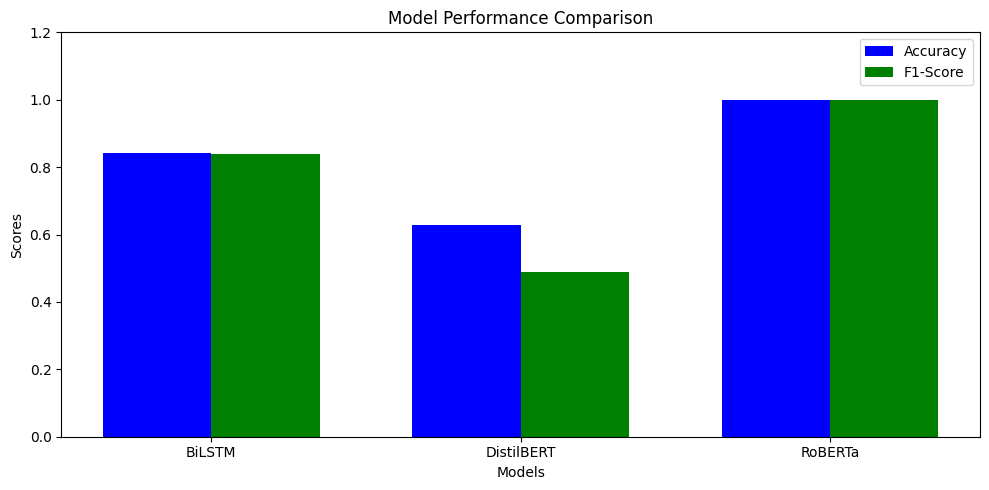

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['BiLSTM', 'DistilBERT', 'RoBERTa']
accuracy = [0.8424, 0.6295, 1.0]
f1_score = [0.84, 0.49, 1.0]

# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
bar_width = 0.35  # Width of the bars
index = np.arange(len(models))

# Bar plots
plt.bar(index, accuracy, bar_width, label='Accuracy', color='blue')
plt.bar(index + bar_width, f1_score, bar_width, label='F1-Score', color='green')

# Titles and labels
plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.xticks(index + bar_width / 2, models)
plt.ylim(0, 1.2)  # To clearly show the differences
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
